# **Trabajo práctico 0: Algoritmo de Maximización de la Esperanza**

Pre-requisitos para el notebook.

In [2]:
import torch
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import style
from scipy.stats import norm
# Requerido para algoritmo de maximización de la esperanza, de lo contrario se mezclan todos los plots.
%matplotlib inline 
style.use('default')

pallet = ["#1F77B4", "#B41F77", "#77B41F"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## **1. (80 puntos) Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gaussiano)**

A continuación, implemente el algoritmo de maximización de la esperanza (descrito en el material del curso), usando la definición y descripción de las siguientes funciones como base:

1. **(15 puntos)** Implemente la función $\textit{generate\_data}$ la cual reciba la cantidad de observaciones unidimensionales total a generar $N$, y los parámetros correspondientes a $K=2$ funciones de densidad **Gaussianas**. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X\in\mathbb{R}^{Nx1}$.

    a) Grafique los datos usando un scatter plot junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad **Gaussianas** usando los parámetros para inicializar los datos, en la misma figura (gráfico). Escoja 3 conjuntos de parámetros para mostrar los 3 dataset resultantes.

In [3]:
MU_SPREAD_COEFFICIENT = 20
MU_SHIFT_COEFFICIENT = 30
SIGMA_SPREAD_COEFFICIENT = 1.5
SIGMA_SHIFT_COEFFICIENT = 3

def generate_data_gaussian(n_observations: int, k_parameters: int = 2) -> torch.Tensor:
    mus = torch.randn(k_parameters) * MU_SPREAD_COEFFICIENT + MU_SHIFT_COEFFICIENT
    sigmas = torch.abs(torch.randn(k_parameters) * SIGMA_SPREAD_COEFFICIENT + SIGMA_SHIFT_COEFFICIENT)
    # Create distributions
    distributions = torch.distributions.Normal(mus, sigmas)
    # Exact samples
    samples = distributions.sample(torch.Size([n_observations,])).t()
    return samples

randomdata = generate_data_gaussian(20)

randomdata

tensor([[38.9411, 39.4658, 40.9676, 39.6846, 41.7082, 38.1515, 41.3073, 36.6007,
         43.0424, 33.4686, 43.1160, 38.2911, 40.7798, 36.8888, 40.9692, 39.1961,
         33.4154, 42.3340, 36.8010, 39.4886],
        [32.0549, 35.0462, 35.5850, 28.5294, 30.6974, 35.7393, 24.7279, 32.7612,
         31.5856, 29.8269, 18.6948, 33.7706, 31.1579, 28.7596, 35.1411, 36.2958,
         28.4681, 31.5995, 28.6132, 41.6654]])

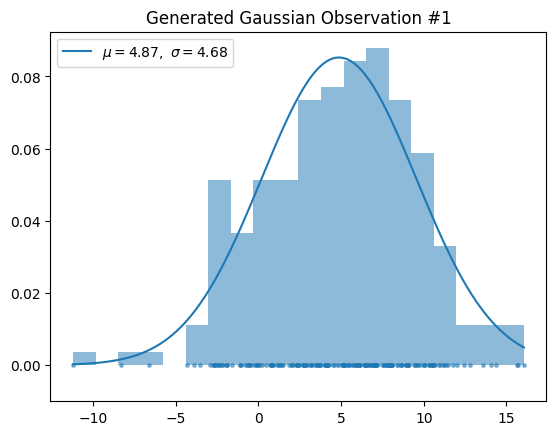

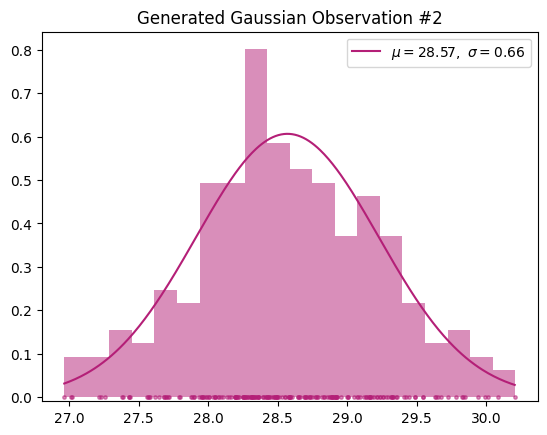

In [6]:
def plot_observation_2(observation, show=True, color=pallet[0], obs_number=1):
    fig, ax = plt.subplots()
    x_axis = torch.arange(observation.min(), observation.max(), 0.01)
    # Histogram
    ax.hist(observation, density=True, bins=20, alpha=0.5, color=color)
    # Scatter Dots
    ax.scatter(observation, torch.zeros(observation.size()), s=6, alpha=0.5, color=color)
    # Gaussian Curve
    mu = torch.mean(observation)
    sigma = torch.std(observation, unbiased=True)
    label = fr'$\mu={round(mu.item(), 2)},\ \sigma={round(sigma.item(), 2)}$'
    ax.plot(x_axis, norm.pdf(x_axis, mu, sigma), color=color, label=label)
    ax.set_title(f"Generated Gaussian Observation #{obs_number}")
    ax.legend()
    # Adjust y-axis
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min - 0.01, y_max)
    if show:
        plt.show()
        
generated_samples = generate_data_gaussian(200)
for index, sample in enumerate(generated_samples):
    plot_observation_2(sample, color=pallet[index % 3], obs_number=index + 1)

2. **(5 puntos)** Implemente la función $\textit{init\_random\_parameters}$ la cual genere una matriz de $P\in\mathbb{R}^{Kx2}$ dimensiones, con los parámetros de las funciones de densidad **Gaussiana** generados completamente al azar.

    a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

In [7]:
#  Genera una matriz k x 2 con mu y sigma aleatorios
def init_random_parameters(k_parameters=2):
    mus = torch.randn(k_parameters) * MU_SPREAD_COEFFICIENT + MU_SHIFT_COEFFICIENT
    sigmas = torch.abs(torch.randn(k_parameters) * SIGMA_SPREAD_COEFFICIENT + SIGMA_SHIFT_COEFFICIENT)
    return torch.stack((mus, sigmas), dim=1)

random_param = init_random_parameters(k_parameters=2)

random_param

tensor([[-12.0457,   3.0193],
        [ 95.7683,   2.4404]])

3. **(20 puntos)** Implemente la función  $\textit{calculate\_likelihood\_gaussian\_observation(x\_n, mu\_k, sigma\_k)}$ la cual calcule la verosimilitud de una observación específica $X_{n}$, para una función de densidad Gaussiana con parámetros $\mu_{k}$ y $\sigma_{k}$.
Realice la correción pertinente al calculo de la función de verosimilitud para evitar el problema de $\textit{under flow}$.

    a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados.

In [32]:
# TODO

4. **(10 puntos)** Implemente la función $\textit{calculate\_membership\_dataset(X\_dataset,Parameters\_matrix)}$, la cual, usando la matriz de parámetros $P$ y la función anteriormente implementada calculate_likelihood_gaussian_observation, defina por cada observación $X_{n}\in X$ la pertenencia o membresía a  cluster $k=1,...,K$, en una matriz binaria $M\in\mathbb{R}^{NxK}$. Retorne tal matriz de membresía $M$.

    a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados

In [33]:
# TODO

5. **(10 puntos)** Implemente la función $\textit{recalculate\_parameters(X\_dataset, Membership\_data)}, la cual recalcule los parámetros de las funciones de densidad Gaussianas representandas en la matriz $P$, de acuerdo a lo representado en la matriz de membresía $M$.

    a)   Use las funciones $\textit{mean}$ y $\textit{std}$ de pytorch para ello. Intente prescindir al máximo de estructuras de repetición tipo $\textit{for}$.

In [34]:
# TODO

6. **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (describalo en una tabla). Hagalo para los 3 conjuntos de datos generados anteriormente.

    a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteración y los parámetros iniciales.

    b) Comente los resultados.

In [35]:
# TODO

7. **(10 puntos)** Proponga una mejor heurística para inicializar los parámetros del modelo aleatoriamente.

    a) Compruebe la mejora obtenida con el método propuesto, corriendo las pruebas del punto anterior.

In [36]:
# TODO